In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [54]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    columns_mapping = {
        "PassengerId": "passenger_id",
        "Survived": "survived",
        "Pclass": "ticket_class",
        "Name": "full_name",
        "Sex": "sex",
        "Age": "age",
        "Ticket": "ticket_number",
        "Fare": "ticket_price",
        "Embarked": "embark_place",
        "SibSp": "sibling_spouses_onboard",
        "Parch" : "parents_children_onboard",
        "Cabin": "cabin_code",
    }
    
    return df.rename(columns=columns_mapping)
    

In [55]:
def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    columns_to_drop = ["cabin_code"]
    return df.drop(columns_to_drop, axis=1)

In [56]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df["family_onboard"] = df["sibling_spouses_onboard"] + df["parents_children_onboard"]
    return df

In [67]:
def null_processing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna(subset=["embark_place"])
    
    df.loc[:, "age"] = df["age"].fillna(df["age"].median())
    
    return df

In [90]:
def pre_process(df: pd.DataFrame) -> pd.DataFrame:
    df = rename_columns(df)
    df = drop_columns(df)
    df = feature_engineering(df)
    df = null_processing(df)
    
    return df
    

In [91]:
test_data = pd.read_csv("data/test.csv")
test_data = pre_process(test_data)
test_data.head()

,passenger_id,ticket_class,full_name,sex,age,sibling_spouses_onboard,parents_children_onboard,ticket_number,ticket_price,embark_place,family_onboard
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,2


In [92]:
train_data = pd.read_csv("data/train.csv")
train_data = pre_process(train_data)
train_data.head()

c:\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,passenger_id,survived,ticket_class,full_name,sex,age,sibling_spouses_onboard,parents_children_onboard,ticket_number,ticket_price,embark_place,family_onboard
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


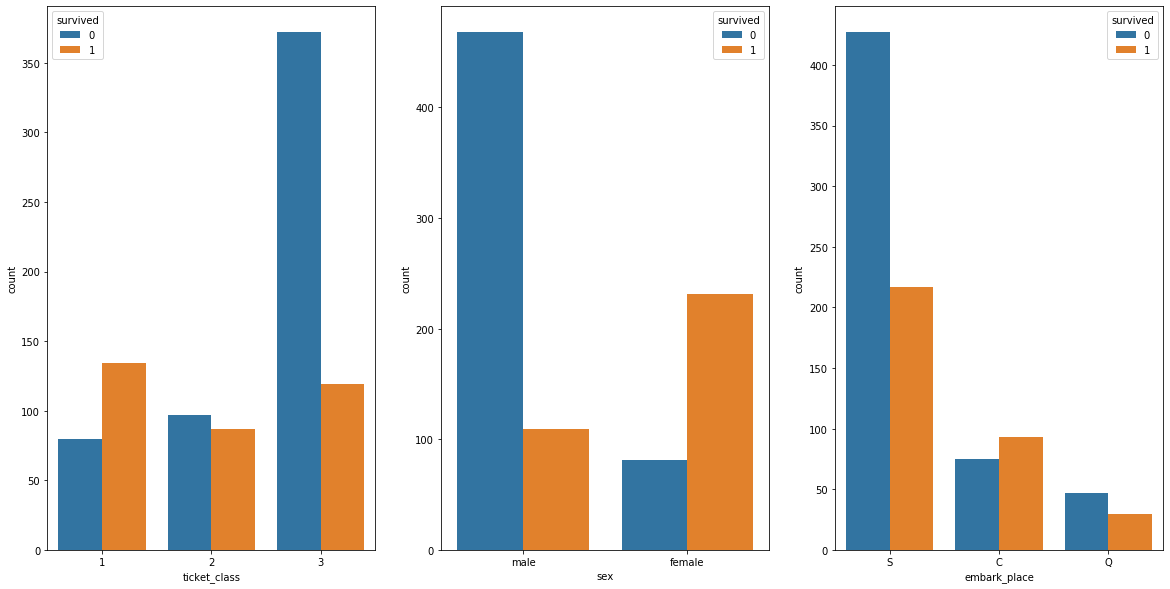

In [70]:
cat_columns = ["ticket_class", "sex", "embark_place"]
_, axs = plt.subplots(ncols=len(cat_columns), figsize=(20, 10))

for i, column in enumerate(cat_columns):
    sns.countplot(x=column, hue="survived", data=train_data, ax=axs[i])

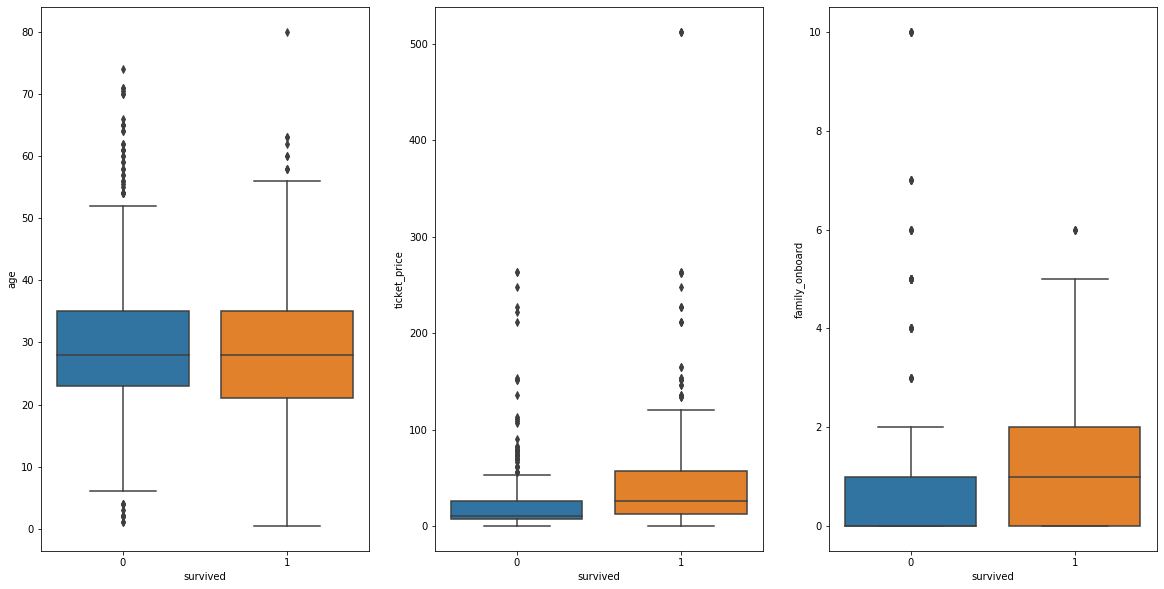

In [71]:
num_columns = ["age", "ticket_price", "family_onboard"]

_, axs = plt.subplots(ncols=len(num_columns), figsize=(20, 10))

for i, column in enumerate(num_columns):
    sns.boxplot(x="survived", y=column, data=train_data, ax=axs[i])

In [72]:
train_data.isna().mean()

passenger_id                0.0
survived                    0.0
ticket_class                0.0
full_name                   0.0
sex                         0.0
age                         0.0
sibling_spouses_onboard     0.0
parents_children_onboard    0.0
ticket_number               0.0
ticket_price                0.0
embark_place                0.0
family_onboard              0.0
dtype: float64

In [93]:
X_train = np.array((train_data.sex == "female").map(int)).reshape(-1, 1)
y_train = train_data.survived

X_test = np.array((test_data.sex == "female").map(int)).reshape(-1, 1)
y_test = test_data.survived

AttributeError: 'DataFrame' object has no attribute 'survived'

In [94]:
model = LogisticRegression()
model.fit(X_train, y_train)

c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
np.sum(model.predict(X_train) - y_train) / len(y_train)

-0.031496062992125984